**QUestion 1:** Image Registration

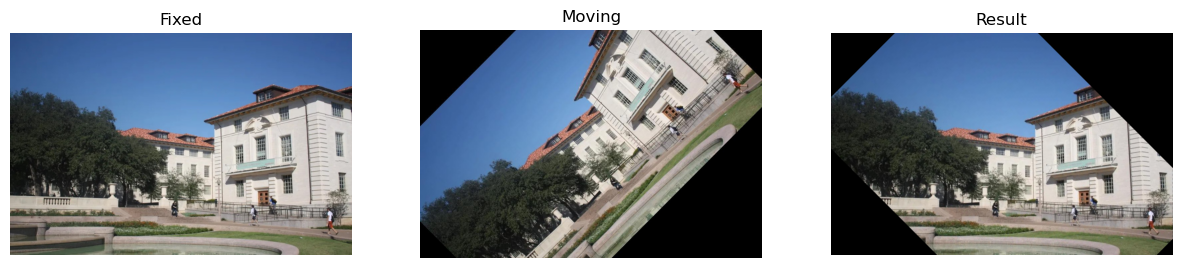

In [44]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

fixed = cv.imread("fixed.png")
moving = cv.imread("moving.jpg")

# Tried grayscaling but found it had no impact
# fixed = cv.cvtColor(fixed, cv.COLOR_BGR2GRAY)
# moving = cv.cvtColor(moving, cv.COLOR_BGR2GRAY)

#SIFT FEATURE DETECTION
sift = cv.SIFT_create()
keypoints_fixed, descriptors_fixed = sift.detectAndCompute(fixed, None)
keypoints_moving, descriptors_moving = sift.detectAndCompute(moving, None)

# FEATURE MATCHING: RANSAC
bf = cv.BFMatcher()
matches = bf.knnMatch(descriptors_fixed, descriptors_moving, k=2)

good_matches = []

for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

good_matches

# tried with 10 as its linear so I thought it might work but needed all the matches
fixed_points = []
moving_points = []

for match in good_matches:
    fixed_points.append(keypoints_fixed[match.queryIdx].pt)
    moving_points.append(keypoints_moving[match.trainIdx].pt)

fixed_points = [list(map(int, point)) for point in fixed_points]
moving_points = [list(map(int, point)) for point in moving_points]

fixed_points, moving_points

fixed_points = np.array(fixed_points, dtype=float)
moving_points = np.array(moving_points, dtype=float)

homography, _ = cv.findHomography(moving_points, fixed_points, cv.RANSAC)
result = cv.warpPerspective(moving, homography, (fixed.shape[1], fixed.shape[0]))


plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title("Fixed")
plt.imshow(cv.cvtColor(fixed, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Moving")
plt.imshow(cv.cvtColor(moving, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title("Result")
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

**Question 2:** Image STitching

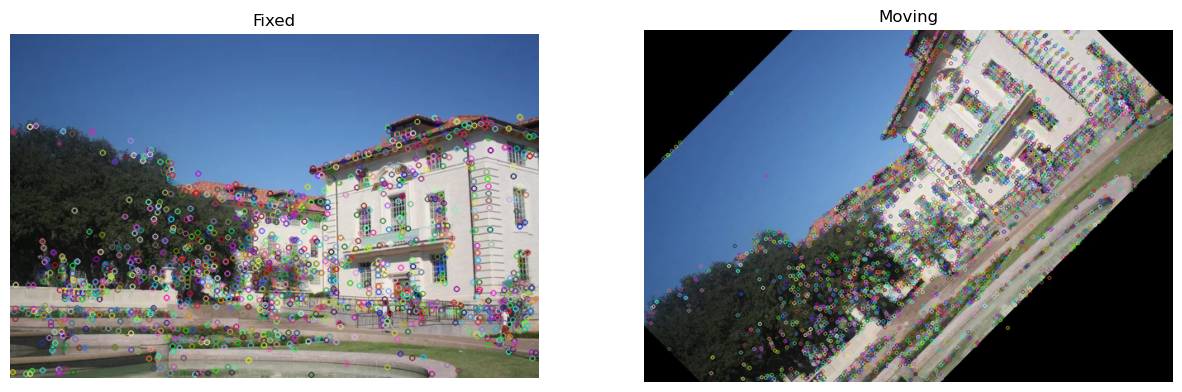

In [45]:
left = cv.imread("left.jpg")
right = cv.imread("right.jpg")

# This is just a visual representation of the images I am doing to help me visualize the keypoints

#SIFT FEATURE DETECTION (same as q1)
sift = cv.SIFT_create()
keypoints_fixed, descriptors_fixed = sift.detectAndCompute(fixed, None)
keypoints_moving, descriptors_moving = sift.detectAndCompute(moving, None)

# show these keypoints on the images
fixed_keypoints = cv.drawKeypoints(fixed, keypoints_fixed, None)
moving_keypoints = cv.drawKeypoints(moving, keypoints_moving, None)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title("Fixed")
plt.imshow(cv.cvtColor(fixed_keypoints, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Moving")
plt.imshow(cv.cvtColor(moving_keypoints, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

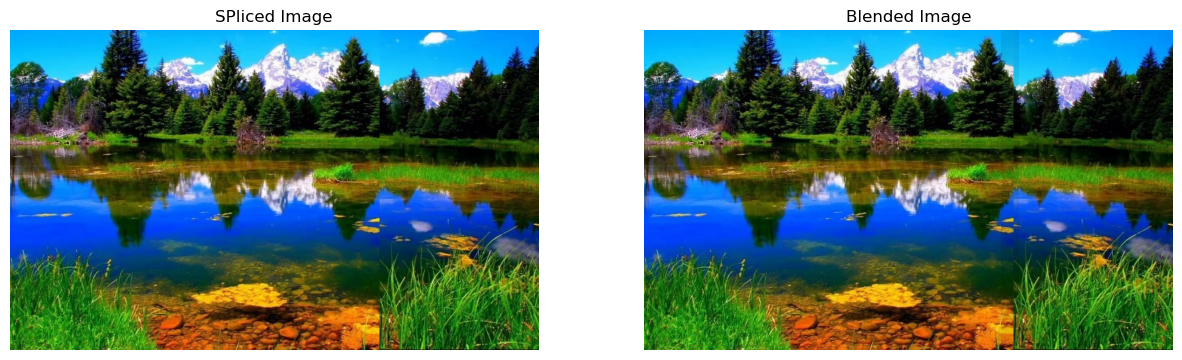

In [245]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

right = cv.imread("right.jpg")
left = cv.imread("left.jpg")

# SIFT FEATURE DETECTION
sift = cv.SIFT_create()
keypoints_right, descriptors_right = sift.detectAndCompute(right, None)
keypoints_left, descriptors_left = sift.detectAndCompute(left, None)

# FEATURE MATCHING: RANSAC
bf = cv.BFMatcher()
matches = bf.knnMatch(descriptors_right, descriptors_left, k=2)
good_matches = []
for m, n in matches:
    if m.distance < .8 * n.distance:
        good_matches.append(m)

right_points = []
left_points = []
for match in good_matches:
    right_points.append(keypoints_right[match.queryIdx].pt)
    left_points.append(keypoints_left[match.trainIdx].pt)

right_points = [list(map(int, point)) for point in right_points]
left_points = [list(map(int, point)) for point in left_points]

right_points = np.array(right_points, dtype=float)
left_points = np.array(left_points, dtype=float)

homography, _ = cv.findHomography(right_points, left_points, cv.RANSAC)
result = cv.warpPerspective(left, homography, (right.shape[1], right.shape[0]))

# drop all the colums in result that are only black
result = result[:, :353]

right_rgb = cv.cvtColor(right, cv.COLOR_BGR2RGB)
result_rgb = cv.cvtColor(result, cv.COLOR_BGR2RGB)

####TODO: blend the right side of the right image and the left side of the result image into eachother for a cleaner result
combined = cv.hconcat((right_rgb, result_rgb))

def blend_images(img1, img2):
    new = []
  
    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape

    max_h = max(h1, h2)
    combined_w = w1 + w2
    blended = np.zeros((max_h, combined_w, 3), dtype=np.uint8)


    blended[:h1, :w1] = img1
    blended[:h2, w1:w1+w2] = img2

    seam_col = w1  # The column to apply the Gaussian blur

    kernel_size = (7, 1)  # Larger kernel size for more pronounced blur
    sigma = 50  # Non-zero sigma value for controlling blur strength
    for i in range(790, 830, 1):
        blurred_seam = cv.GaussianBlur(blended[:, i:i+1], kernel_size, sigma, borderType=cv.BORDER_REPLICATE)
        blended[:, i] = blurred_seam[:, 0]/1.08  # Replace the i-th column in the blended image with the blurred column
        # blended[:, i] = cv.addWeighted(blended[:, i], 0.5, blurred_seam[:, 0], 0.5, 0)
        #make blended[:, i] = black
        # blended[:, i] = [0, 0, 0]



    return blended




# Plot the blended image
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(combined)
plt.title('SPliced Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Blended Image")
plt.imshow(blend_images(right_rgb, result_rgb))
plt.axis("off")
plt.show()